# <center> <b> <font color='blue'> ELECTRICAL PRODUCTION </center> </b> </font>

## Table of Contents

1. [Problem Statement](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data Loading and pre-processing](#4)
5. [Models](#5)
6. [Comparing results](#6)
7. [Hyperparameter Tuning](#7)
8. [References](#References)

<a name="1"></a>
## <font color='#2e86c1'> <b> 1. Problem Statement </font> </b>

We're gonna predict the electrical production. It is a time series problem.

<a name="2"></a>
## <font color='#2e86c1'> <b> 2. Setup </font> </b>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
import pandas as pd
from tensorflow.keras import layers
import keras_tuner as kt
import keras_tuner
from keras import backend as K

In [4]:
tf.get_logger().setLevel('ERROR')

<a name="3"></a>
## <font color='#2e86c1'> <b> 3. Helper Functions </font> </b>

### Ploting

In [5]:
def plot_series(time, series, title, xlabel, ylabel, format="-", start=0, end=None, color='blue'):
    plt.plot(time[start:end], series[start:end], format, color=color)

    # Show only some x values to avoid clutter
    ticks_interval = 50
    plt.xticks(data.index[::ticks_interval], data.index[::ticks_interval])
    
    # Set title with bold and colored text
    plt.title(title, fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'darkred'})
    
    # Set xlabel with bold and colored text
    plt.xlabel(xlabel, fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'darkorange'})
    
    # Set ylabel with bold and colored text
    plt.ylabel(ylabel, fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'darkorange'})
    
    plt.grid(True)
    plt.show()  # Show the plot if desired

    

def plot_train_val(time_train, series_train, time_valid, series_valid):
    plt.figure(figsize=(12, 6))
    plt.plot(time_train, series_train, label='Training Set', color='blue')
    plt.plot(time_valid, series_valid, label='Validation Set', color='orange')

    # Show only some x values to avoid clutter
    ticks_interval = 50
    plt.xticks(data.index[::ticks_interval], data.index[::ticks_interval])

    # Adding titles and labels
    plt.title('Training and Validation Sets')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.axvline(x=time_train[-1], color='red', linestyle='--', label='Split Point')  # Optional: Split line
    plt.legend()
    plt.grid()
    plt.show()
    

    
def plot_history(history):
    # Assuming `history` is the output from model.fit()
    # Example: history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)  # One row, two columns, first subplot
    plt.plot(history.history['loss'], label='Training Loss ')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training & validation MSE
    plt.subplot(1, 2, 2)  # One row, two columns, second subplot
    plt.plot(history.history['mse'], label='Training MSE')
    if 'val_mse' in history.history:
        plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('Model Mean Squared Error')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    
    
    
def plot_comparison(time, true_values, preds):
    plt.figure(figsize=(10, 5))  # Optional: Set the figure size
    plt.plot(time, preds, label='Preds', color='blue')  # Plot the first array
    plt.plot(time, true_values, label='True', color='orange')  # Plot the second array

    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('Series')
    plt.title('True vs pred')
    plt.legend()  # Show legend
    plt.grid(True)  # Optional: Add a grid


    # Set x-ticks to show only specific labels
    plt.xticks(np.arange(0, 100, 50))  # Show ticks from 0 to 10 with a step of 1

    # Show the plot
    plt.show()
    
    
def plot_model_metrics(results):
    # Extract data
    models = list(results.keys())
    metrics = list(results[models[0]].keys())
    values = {metric: [] for metric in metrics}

    for model in models:
        for metric in metrics:
            values[metric].append(results[model][metric])

    x = np.arange(len(models))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each metric
    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, values[metric], width, label=metric)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Models', fontweight='bold')
    ax.set_ylabel('Value', fontweight='bold')
    ax.set_title('Comparison of Models by Metrics', fontweight='bold', color='#12222C')
    ax.set_xticks(x + width * (len(metrics) / 2 - 0.5))
    ax.set_xticklabels(models)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

### Train/test split

In [6]:
# train/test split
def train_val_split(time, series, split_size):
    """
    Split the time series data into training and validation sets.
    We do not shuffle the data because is a time series problem.

    Parameters:
    - time (list-like): List or array containing the time index of the time series.
    - series (list-like): List or array containing the values of the time series.
    - split_size (float): The proportion of data to be allocated for training.
                          Value should be between 0 and 1.

    Returns:
    - time_train (list-like): Time index of the training set.
    - series_train (list-like): Values of the training set.
    - time_valid (list-like): Time index of the validation set.
    - series_valid (list-like): Values of the validation set.

    Example:
        If time = [1, 2, 3, 4, 5] and series = [10, 20, 30, 40, 50],
            and split_size = 0.8, then the function returns:
                time_train = [1, 2, 3]
                series_train = [10, 20, 30]
                time_valid = [4, 5]
                series_valid = [40, 50]
    """
    
    # índice de la divisón
    training_size = int(len(time)*split_size)

    time_train = time[:training_size]
    series_train = series[:training_size]
    time_valid = time[training_size:]
    series_valid = series[training_size:]

    return time_train, series_train, time_valid, series_valid

### Windowing

In [7]:
def windowed_dataset(series, 
                     window_size=7, 
                     horizon=1, 
                     batch_size=32, 
                     shuffle_buffer=10,
                     shuffle=True):
    
    """
    Create a windowed dataset for time series prediction.

    Parameters:
    - series: 1D array-like structure containing the time series data.
    - window_size: Size of the window for features.
    - horizon: 
    - batch_size: Number of samples per batch.
    - shuffle_buffer: Size of the shuffle buffer.
    - shuffle: Boolean indicating whether to shuffle the dataset.

    Returns:
    - A TensorFlow dataset of input-output pairs.
    """
    
    if window_size <= 0 or batch_size <= 0:
        raise ValueError("window_size and batch_size must be greater than 0")
    
    # Create the dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create windows of size (window_size + horizon)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    
    # Flatten the windows into batches
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Split the windows into features and labels
    # w[:-horizon]: all but the last 'horizon' elements for features
    # w[-horizon:]: the last 'horizon' elements for labels
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:]))  # Use -horizon for labels
    
    # Batch the dataset
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Predictions

In [8]:
def forecast(model, initial_window, num_predictions, verbose=False):
    """
    Forecasts future values using a sliding window approach, making one prediction at a time 
    and updating the window with each prediction.
    
    Args:
        model: The trained model used for making predictions. It should accept an input of shape (1, window_size).
        initial_window (numpy.ndarray): The initial window of data to start the forecasting process. 
            It should have the same shape as the model's input.
        num_predictions (int): The total number of predictions to generate.
        
    Returns:
        numpy.ndarray: An array containing the predicted values, with length equal to `num_predictions`.
        
    Notes:
        The function assumes that the model is trained for one-step ahead forecasting and 
        updates the input window after each prediction.
    """
    
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window
    

    # Make predictions until the desired number is reached
    while len(predictions) < num_predictions:
        
        # Make a prediction for one step ahead
        pred = model.predict(current_window[np.newaxis], verbose=0)
        pred_step = pred[0][0]  # Extract the predicted step (single value)
        
        # Log predictions if verbose is True
        if verbose:
            print(f"Predicting on: \n {current_window} -> Prediction: {pred_step}\n")

        # Add the prediction to the list
        predictions.append(pred_step)

        # Update the window: remove the oldest value and add the new prediction
        current_window = np.roll(current_window, -1)  # Shift left by one step
        current_window[-1] = pred_step  # Insert the new prediction at the end

        
    return np.array(predictions[:num_predictions])  # Return exactly num_predictions values


### Calculate metrics and store results

In [9]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
 
    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}


def store_results(results, name, data):
    
    # Store the data in the results dictionary
    results[name] = data
    
    return results

<a name="4"></a>
## <font color='#2e86c1'> <b> 4. Loading and pre-processing data </font> </b>

This project uses the [Electric Production](https://www.kaggle.com/datasets/shenba/electricity-production) dataset by Kaggle.

### Loading data

In [10]:
!cd data && ls

Electric_Production.csv


In [11]:
data = pd.read_csv('data/Electric_Production.csv')
data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


### Exploration

In [12]:
data.shape

(397, 2)

In [13]:
data.columns

Index(['DATE', 'IPG2211A2N'], dtype='object')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [15]:
data.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

There are no missing values.

In [16]:
times = data['DATE']
consumption = data['IPG2211A2N']

In [17]:
# Class for storing data
@dataclass
class G:
    #TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    #times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = times.values
    SERIES = consumption.values
    SPLIT_TIME = 250
    WINDOW_SIZE = 7
    HORIZON = 1
    BATCH_SIZE = 64
    SHUFFLE_BUFFER_SIZE = 200
    SPLIT_SIZE=0.8

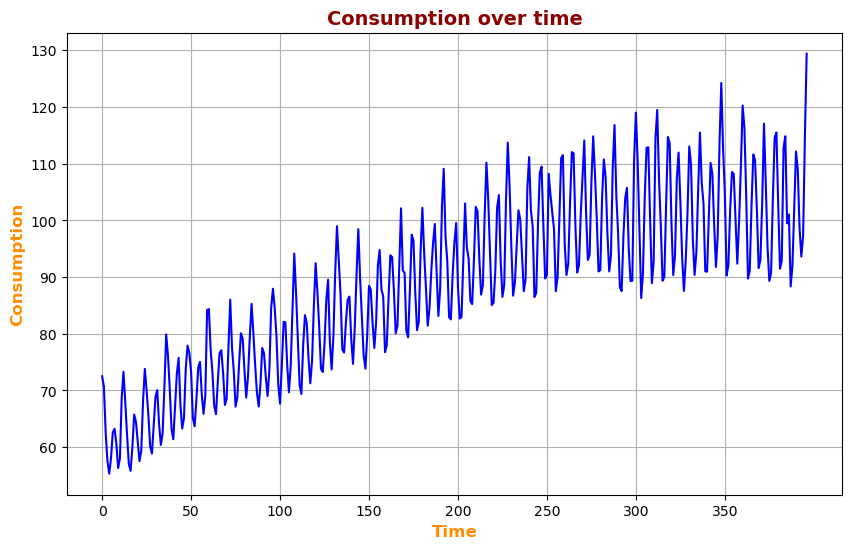

In [18]:
# plot time series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, 'Consumption over time', 'Time', 'Consumption')
plt.show()

We can see a growing trend.

### Train/Test split

In [19]:
len(G.TIME)

397

In [20]:
int(len(G.TIME)*G.SPLIT_SIZE)

317

In [21]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_SIZE)

In [22]:
time_train.shape, series_train.shape, time_valid.shape, series_valid.shape

((317,), (317,), (80,), (80,))

Let's plot our sets.

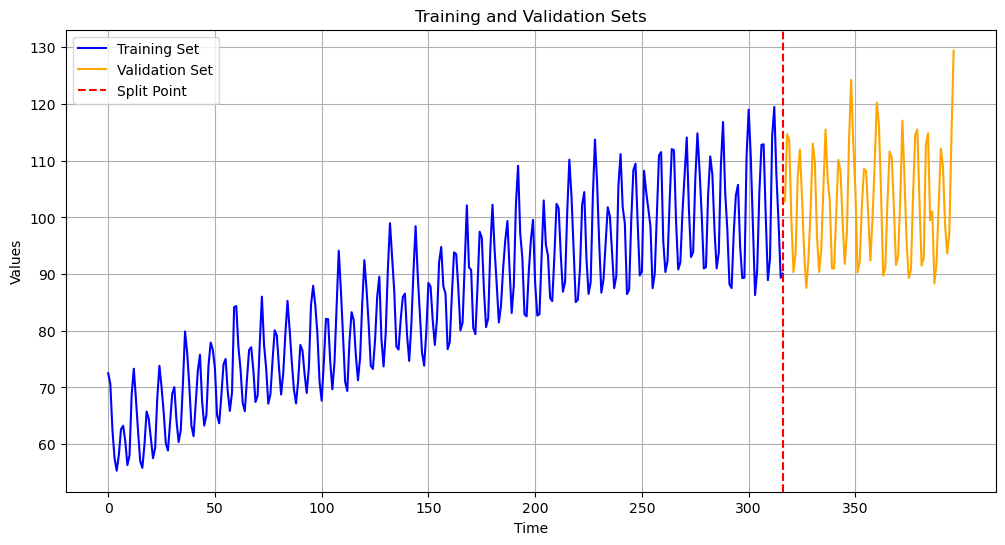

In [23]:
plot_train_val(time_train, series_train, time_valid, series_valid)

### Windowing the dataset

In [24]:
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, 
                             batch_size=G.BATCH_SIZE,shuffle=True)

In [25]:
# Apply to the validation set; NO shuffle
val_set = windowed_dataset(series_valid, window_size=G.WINDOW_SIZE, 
                           batch_size=G.BATCH_SIZE,shuffle=False)

<a name="5"></a>
## <font color='#1a5276'> <b> 5. Models </font> </b>

In [26]:
tf.random.set_seed(42)

results = {}

<a name="5.0"></a>
### <font color='#2874a6'> <b> 5.0. Baseline </font> </b>

In [27]:
aux = G.SERIES[:-81]
len(aux), len(G.SERIES)

(316, 397)

In [28]:
# naive forecast
naive_forecast = G.SERIES[-len(series_valid)-1:-1]

naive_forecast.shape


(80,)

In [29]:
naive_results = evaluate_preds(y_true=series_valid,
                               y_pred=naive_forecast)

In [30]:
naive_results

{'mae': 8.326281, 'mse': 90.36039, 'rmse': 9.505808, 'mape': 8.093309}

In [31]:
store_results(results, 'Naive Forecast', naive_results)

{'Naive Forecast': {'mae': 8.326281,
  'mse': 90.36039,
  'rmse': 9.505808,
  'mape': 8.093309}}

In [32]:
# Find average price
tf.reduce_mean(series_valid).numpy()

102.71854125

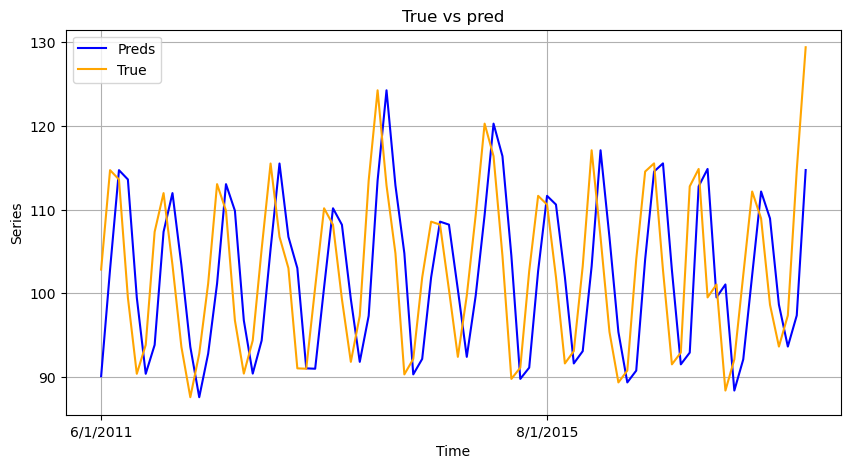

In [33]:
plot_comparison(time_valid, series_valid, naive_forecast)

<a name="5.1"></a>
### <font color='#2874a6'> <b> 5.1. Simple Dense Model </font> </b>

<img src="images/model1.png"/>

In [34]:
def build_compile_model_one(name, horizon=G.HORIZON, window_size=G.WINDOW_SIZE, num_features=1):
    # Construct model
    model = tf.keras.models.Sequential([
      #layers.InputLayer(input_shape=(window_size, num_features)),  # Explicit input layer
      layers.InputLayer(input_shape=[window_size]),
      layers.Dense(128,activation='relu'),
      layers.Dense(horizon, activation="linear")                 
    ], name=name)

    # Compile model
    model.compile(loss="mse",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mse"])
    
    return model


model_1 = build_compile_model_one('Simple_Dense')
model_1.summary()

Model: "Simple_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# Fit the model
history_one = model_1.fit(
            train_set,
            epochs=100,
            verbose=0,
            batch_size=64,
            validation_data=val_set)

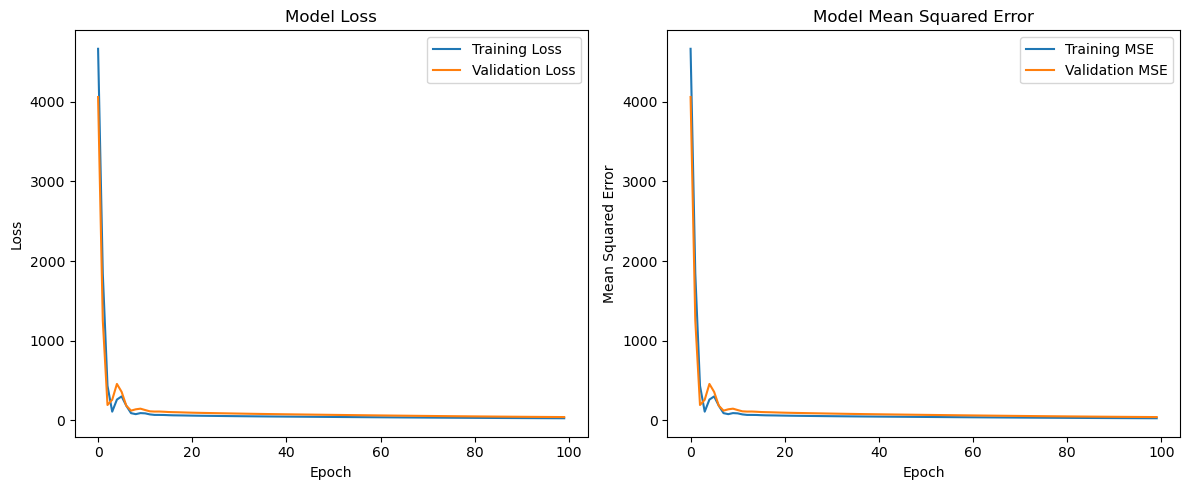

In [36]:
plot_history(history_one)

Now we are going to calculate the predictions. Our initial window will consist of the first 'window size' elements from the val set.

In [39]:
series_valid[:G.WINDOW_SIZE]

array([102.8204, 114.7068, 113.5958,  99.4712,  90.3566,  93.8095,
       107.3312])

In [51]:
series_valid

array([102.8204, 114.7068, 113.5958,  99.4712,  90.3566,  93.8095,
       107.3312, 111.9646, 103.3679,  93.5772,  87.5566,  92.7603,
       101.14  , 113.0357, 109.8601,  96.7431,  90.3805,  94.3417,
       105.2722, 115.501 , 106.734 , 102.9948,  91.0092,  90.9634,
       100.6957, 110.148 , 108.1756,  99.2809,  91.7871,  97.2853,
       113.4732, 124.2549, 112.8811, 104.7631,  90.2867,  92.134 ,
       101.878 , 108.5497, 108.194 , 100.4172,  92.3837,  99.7033,
       109.3477, 120.2696, 116.3788, 104.4706,  89.7461,  91.093 ,
       102.6495, 111.6354, 110.5925, 101.9204,  91.5959,  93.0628,
       103.2203, 117.0837, 106.6688,  95.3548,  89.3254,  90.7369,
       104.0375, 114.5397, 115.5159, 102.7637,  91.4867,  92.89  ,
       112.7694, 114.8505,  99.4901, 101.0396,  88.353 ,  92.0805,
       102.1532, 112.1538, 108.9312,  98.6154,  93.6137,  97.3359,
       114.7212, 129.4048])

In [57]:
preds_model_1 = forecast(model_1, series_valid[:G.WINDOW_SIZE], len(series_valid)-G.WINDOW_SIZE)

In [58]:
preds_model_1.shape

(73,)

Let's calculate the metrics.

In [59]:
model_1_results = evaluate_preds(series_valid[G.WINDOW_SIZE:], preds_model_1) # if we use series_valid
            # we start to compare after the initial window
model_1_results

{'mae': 8.753564, 'mse': 115.754105, 'rmse': 10.758908, 'mape': 8.947592}

In [60]:
store_results(results, 'Model 1 (Simple Dense)', model_1_results);

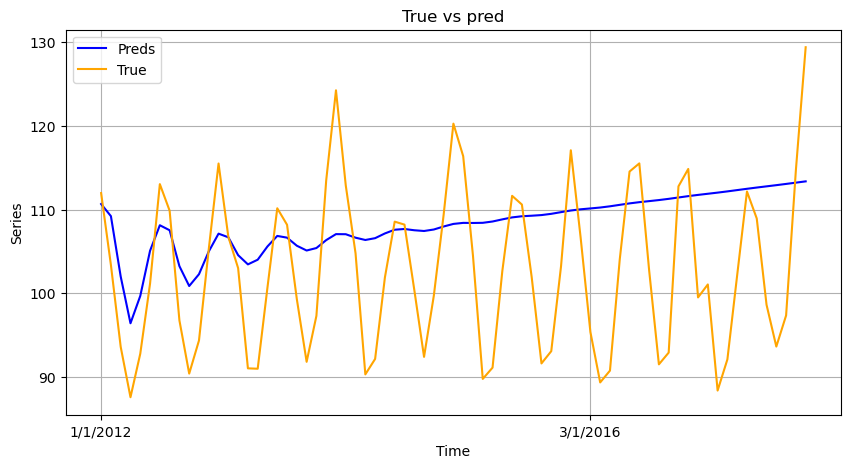

In [68]:
plot_comparison(time_valid[G.WINDOW_SIZE:], series_valid[G.WINDOW_SIZE:], preds_model_1)

We can see that our predictions start well, but then, as time goes by, they get worse and worse.

<a name="5.2"></a>
### <font color='#2874a6'> <b> 5.2. RNNs </font> </b>

As mentioned in the documentation, SimpleRNN layers expect a 3-dimensional tensor input with the shape **[batch, timesteps, number of features]**. With that, you need to reshape your window from (64, 7) to (64, 7, 1). This means the 7 datapoints in the window will be mapped to 7 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using Lambda layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the input_shape, you can specify None if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to window_size as shown below if you want to set the timesteps dimension to the expected size of your data windows.


<img src="images/model2.png"/>

In [69]:
def build_compile_model_two(name, horizon=G.HORIZON, window_size=G.WINDOW_SIZE):
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[window_size]),
                        # if we want to be more flexible, we can write input_shape=[None]
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(horizon),
        tf.keras.layers.Lambda(lambda x: x*100.0) # scaling to around the same figure as your labels
    ], name=name) 
    
    
    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mse"]) 

    return model


model_2 = build_compile_model_two('LSTM_Model')
model_2.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 7, 1)              0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 7, 256)            133120    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 297601 (1.14 MB)
Trainable params: 297601 

In [70]:
# Fit the model
history_2 = model_2.fit(
            train_set,
            epochs=100,
            verbose=0,
            batch_size=G.BATCH_SIZE,
            validation_data=val_set)

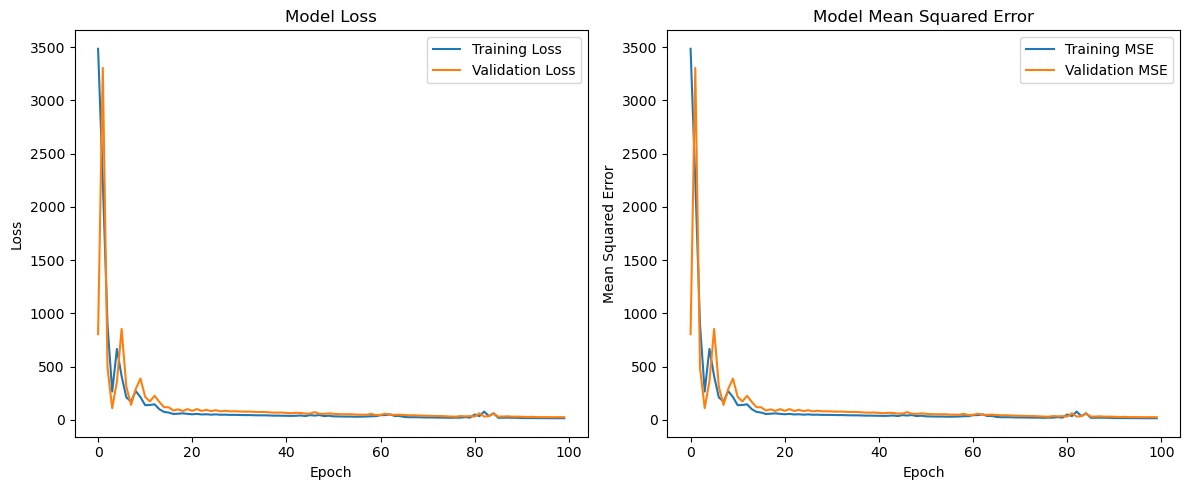

In [71]:
plot_history(history_2)

In [72]:
preds_model_2 = forecast(model_2, series_valid[:G.WINDOW_SIZE], len(series_valid)-G.WINDOW_SIZE)

In [73]:
preds_model_2.shape

(73,)

In [75]:
model_2_results = evaluate_preds(series_valid[G.WINDOW_SIZE:], preds_model_2)
model_2_results

{'mae': 6.645339, 'mse': 69.1291, 'rmse': 8.314391, 'mape': 6.5396643}

In [76]:
store_results(results, 'Model 2: LSTM', model_2_results);

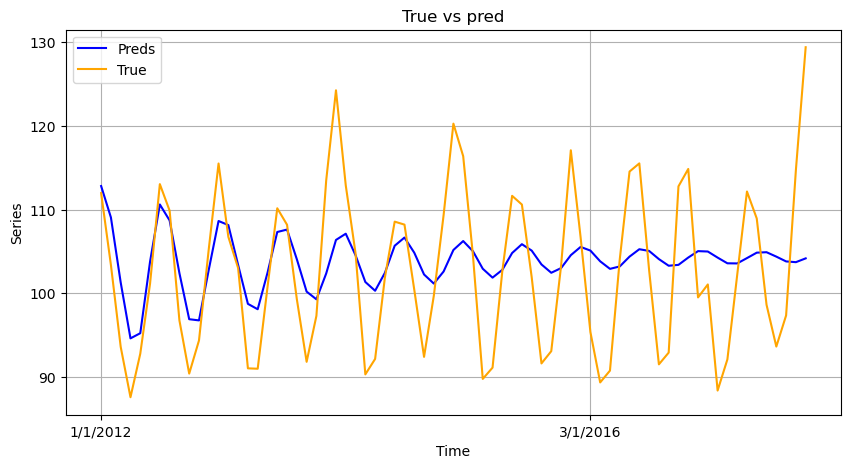

In [77]:
plot_comparison(time_valid[G.WINDOW_SIZE:], series_valid[G.WINDOW_SIZE:], preds_model_2)

<a name="6"></a>
## <font color='#1a5276'> <b> 6. Comparing results </font> </b>

In [78]:
# Convert dictionary to DataFrame
df_metrics = pd.DataFrame(results).T  # .T transposes the DataFrame for easier viewing
df_metrics.reset_index(inplace=True)
df_metrics.rename(columns={'index': 'Model'}, inplace=True)

# Display the DataFrame
df_metrics

,Model,mae,mse,rmse,mape
0,Naive Forecast,8.326281,90.360390,9.505808,8.093309
1,Model 1 (Simple Dense),8.753564,115.754105,10.758908,8.947592
2,Model 2: LSTM,6.645339,69.129097,8.314391,6.539664


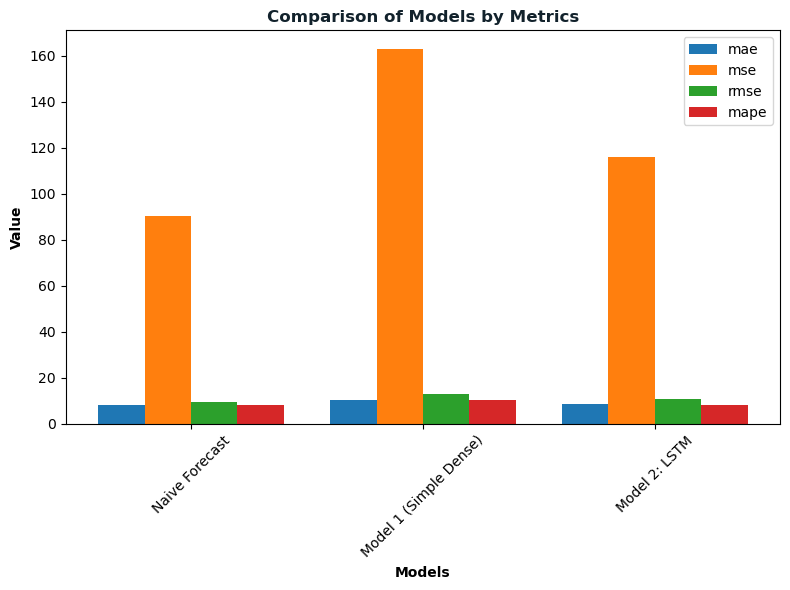

In [59]:
# Let's plot  
plot_model_metrics(results)

The LSTM yields the best results across the different metrics. Let's see if we can beat it with the first model.

<a name="7"></a>
## <font color='#1a5276'> <b> 7. Hyperparameter Tuning </font> </b>

In [79]:
class MyHyperModel(keras_tuner.HyperModel) :
     def build(self, hp, horizon=G.HORIZON, window_size=G.WINDOW_SIZE):
            
            
        # Define input layer
        inputs = layers.Input(shape=[window_size]) # (window_size, )

        # Dense layer with a fixed number of units
        dense_layer = layers.Dense(hp.Choice('number_neurons',[32, 64, 96, 128, 256, 512]), 
                                   activation='relu')(inputs)
        

        # Output layer
        outputs = layers.Dense(horizon, activation="linear")(dense_layer)

        # Create the model
        #model = models.Model(inputs=inputs, outputs=outputs)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        # Compile the model
        model.compile(optimizer=hp.Choice('optim',['adam','adamax']),
                      loss='mse',
                      metrics = ['mse'])
        
        # A way to optimize the learning rate while also trying different optimizers
        learning_rate = hp.Choice('lr', [ 0.03, 0.01, 0.003])
        K.set_value(model.optimizer.learning_rate, learning_rate)
                    
        return model

In [80]:
tuner = kt.BayesianOptimization(
                        hypermodel=MyHyperModel(),
                        objective = "val_mse",
                        max_trials = 10,
                        overwrite=True,
                        directory='search_dir',
                        project_name='electrical_prod_forecasting')

In [81]:
tuner.search(x=train_set, epochs=50,
             validation_data=val_set)

Trial 10 Complete [00h 00m 05s]
val_mse: 53.56936264038086

Best val_mse So Far: 24.892887115478516
Total elapsed time: 00h 00m 48s


In [82]:
tuner.results_summary(1)

Results summary
Results in search_dir/electrical_prod_forecasting
Showing 1 best trials
Objective(name="val_mse", direction="min")

Trial 02 summary
Hyperparameters:
number_neurons: 32
optim: adam
lr: 0.003
Score: 24.892887115478516


In [83]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_2 (Dense)             (None, 32)                256       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 289 (1.13 KB)
Trainable params: 289 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [84]:
"""
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras",save_best_only=True),
]
"""

history = model.fit(
                  train_set, 
                  validation_data=val_set,
                  epochs=100, 
                  verbose=0,
                  batch_size=G.BATCH_SIZE)                  
                  #callbacks=callbacks)

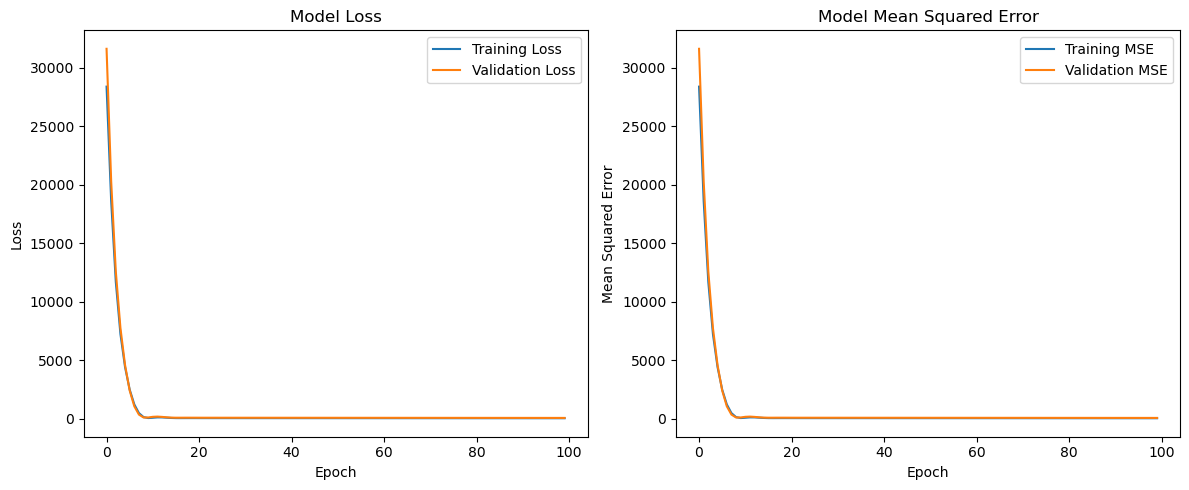

In [85]:
plot_history(history)

In [86]:
preds_model = forecast(model, series_valid[:G.WINDOW_SIZE], len(series_valid)-G.WINDOW_SIZE)

model_results = evaluate_preds(series_valid[G.WINDOW_SIZE:], preds_model)

model_results

{'mae': 8.921273, 'mse': 111.2694, 'rmse': 10.548431, 'mape': 9.021565}

In [87]:
model_2_results

{'mae': 6.645339, 'mse': 69.1291, 'rmse': 8.314391, 'mape': 6.5396643}

We improve, but not enough.

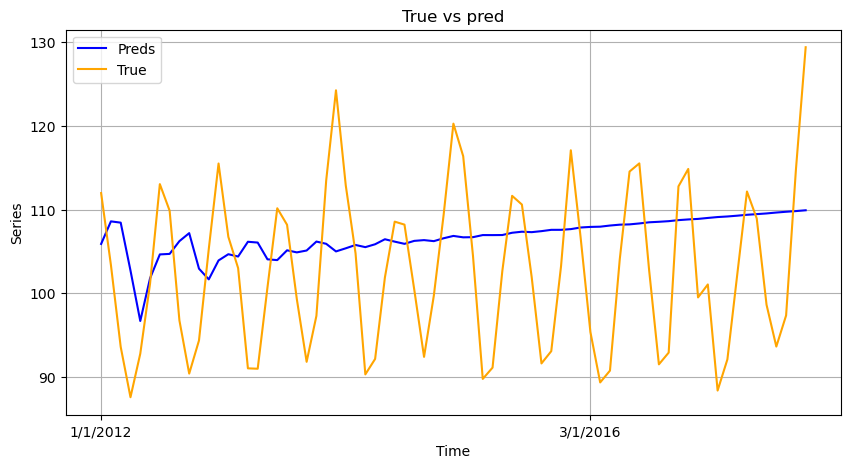

In [89]:
plot_comparison(time_valid[G.WINDOW_SIZE:], series_valid[G.WINDOW_SIZE:], preds_model)

<a name="References"></a>
## <font color='#1a5276'> <b> 8. References </font> </b>

[DeepLearning.AI TensorFlow Developer Professional Certificate](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction?specialization=tensorflow-in-practice)

[TensorFlow for Deep Learning Bootcamp](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/?couponCode=MTST7102224B2)

